# Transmission Federate

Having explored the fundamental concepts of transmission-distribution co-simulation in the previous notebook, we now turn to the practical implementation of the transmission system federate. This notebook demonstrates how to configure ANDES as a HELICS federate that simulates the transmission network and exchanges data with the distribution system simulator. The implementation here brings to life the theoretical concepts we studied, showing how voltage and power data flow between the two domains in a synchronized manner.

## Overview

In the cosim-fundamentals notebook, we manually calculated power flow across a T&D interface and understood why separate simulators are necessary. We learned that transmission systems provide voltage (magnitude and angle) while distribution systems provide power demand (P and Q). Now we'll implement this data exchange using HELICS to coordinate ANDES (transmission) and OpenDSS (distribution) automatically.

This implementation uses the IEEE 14-bus transmission system, with bus 4 serving as the interface to the distribution network. The transmission federate subscribes to power values from the distribution system and publishes voltage values back, creating the bidirectional coupling essential for accurate T&D analysis.

## HELICS Federation Terminology

Before going into the code, let's clarify the key terms we'll encounter. A **simulator** is the executable that performs analysis functions, in our case ANDES for transmission dynamics. A **federate** is an individual simulator participating in the co-simulation, exchanging information with other federates. The **core** manages interactions among federates, while the **broker** coordinates multiple cores, passing signals between federates. Together, all federates executing in a single co-simulation form the **federation**.

## Co-simulation Execution Stages

Every HELICS co-simulation progresses through four distinct stages that ensure proper synchronization and data exchange between federates.

### Creation Stage
During creation, we register ANDES as a component of the HELICS federation, establishing time synchronization and data exchange interfaces. This process configures how our transmission federate will communicate with the distribution federate.

### Initialization Stage
The initialization phase allows both federates to prepare for time-stepping. Here, federates can exchange initial values to achieve a consistent starting state. For our transmission system, this means running an initial power flow to establish steady-state conditions before beginning the dynamic simulation.

### Execution Stage
Once initialization completes, federates enter the main simulation loop by calling `helicsEnterExecutingMode()`. The simulation time starts at zero, and values published during initialization become available. In each time step, our transmission federate receives power values, updates its load model, runs a dynamic simulation step, and publishes resulting voltages.

### Finalization Stage
After simulating the required time period, the federate properly disconnects using `destroy_federate()`, notifying the broker that it's exiting and freeing up resources. This ensures clean termination of the co-simulation.


## Transmission and Distribution Co-simulation Architecture

The co-simulation framework employs HELICS to synchronize the transmission and distribution simulators, enabling structured data exchange at each time step. The information flow follows a sequential pattern that ensures robust simulation through careful timing coordination. As illustrated in Figure 1, the simulation progresses through time with each federate maintaining its own state while exchanging critical interface variables.

![Fig. 1. Simulation Flow in terms of Simulation time [2]](simulation_flow.jpeg)

**Fig. 1. Simulation Flow in terms of Simulation time [2]**

The sequential exchange pattern we implement here avoids the complexity of iterative solutions while still capturing the essential T&D interactions. At each time step, the transmission federate sends voltage information to the distribution federate, which uses this to solve its power flow. The distribution federate then returns the total power demand, which becomes the load at the transmission interface bus for the next time step. This approach mirrors the manual calculation from our conceptual introduction but automates it across many time steps.

## Integration with HELICS
The HELICS co-simulation platform supports simulators operating across multiple time domains, with simulation time synchronization managed implicitly by a broker[2]. As shown in Fig. 2 the innformation exchange is facilitated through either subscriptions/publications or endpoint communications. The HELICS command-line interface (helics-cli) can be used within a terminal script to initiate co-simulations, allowing all simulators to run simultaneously. Additionally, variations in communication latency and packet loss can be modeled at the endpoints, enabling the simulation of cyber-physical interactions. In this example, the co-simulation platform integrates HELICS, ANDES, and OpenDSS.

![Fig. 2. Co-simulation integration in HELICS [2]](helics_integration.jpg)

**Fig. 2. Co-simulation integration in HELICS [2]**


::: {admonition} Execute Two Notebooks Simultaneously
:class: warning

To execute the complete T&D co-simulation, you must run both this notebook (`transmission_federate.ipynb`) and the companion `distribution_federate.ipynb` simultaneously. Open both notebooks in separate browser tabs or Jupyter Lab panels, then run all cells in both notebooks at once. The HELICS broker will coordinate the execution, ensuring proper synchronization between the federates. If one federate starts before the other, it will wait at the execution mode entry point until both are ready to proceed.

:::

## Required Libraries

First, we import the necessary libraries for our transmission federate.

In [1]:
import os
import sys
import time
import numpy as np
import helics as h
import pandas as pd
import matplotlib.pyplot as plt
import andes
import scipy.stats
import scipy.io as readmat
import os

## Initialization to start a broker 

Here, we initialize the main broker for this federate with two connected federates. The number '2' represents the number of federates being connected.

In [2]:
helicsversion = h.helicsGetVersion()
print("Helics version = {}".format(helicsversion))
brokerinitstring = "-f 2 --name=mainbroker" 

Helics version = 3.6.1 (2025-02-24)


## Create a broker
HELICS utilizes various underlying communication technologies to facilitate coordination among co-simulation components. Some of these technologies, like ZeroMQ (zmq), are designed to be broadly applicable. Here zmq core is used while creating a broker.

In [3]:
broker = h.helicsCreateBroker("zmq", "", brokerinitstring)
isconnected = h.helicsBrokerIsConnected(broker)
if isconnected == 1:
    print("Broker created and connected")

Broker created and connected


## Create a Transmission Federate info object

First, create a Federate Info object to define the federate's properties and set the core type using fedstring. Note that the minimum time step in HELICS is 1 nanosecond. A time delta of 0.01 represents the smallest interval at which the federate can receive updates if a publication occurs at 0 seconds. However, since publications take place every second in this co-simulation, the federate will receive updates at one-second intervals.

In [4]:
federate_name="Transmission"
fedinfo = h.helicsCreateFederateInfo()
fedinitstring = "--broker=mainbroker --federates=1" 
h.helicsFederateInfoSetCoreName(fedinfo, f"{federate_name}") 
h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq") 
h.helicsFederateInfoSetCoreInitString(fedinfo, fedinitstring) 
h.helicsFederateInfoSetTimeProperty(fedinfo, h.helics_property_time_delta, 0.01)

## Create a value federate

Based on the type of data exchange, the federate is created. Here, we create a value federate, as the federates simulate the physics of the system. Value federates provide information about the physical values of the system with associated units. Since the signals for publication and subscription are power and voltage, both federates in this co-simulation are value federates.

In [5]:
fed = h.helicsCreateValueFederate(f"{federate_name}", fedinfo)
print(f"{federate_name}: Value federate created", flush=True)

Transmission: Value federate created


Set the publication and subscription items in a dictionary and register the publications and subscriptions.

In [6]:
PUBLICATIONS = {}
SUBSCRIPTIONS = {}
publications={
    "transmission_voltage/bus_4": {
      "pub_interval": 1,
      "type": "complex",
      "global": True,
      "unit": "pu",
      "vbase": 69,
      "vbase_unit": "kv",
      "topic": "TransmissionSim/Voltage_4",
      "value": "Voltage",
      "element_name": "4",
      "element_type": "Bus"
    }
}
subscriptions={
    "34Bus": {
      "type": "complex",
      "required": True,
      "sub_interval": 1,
      "topic": "34Bus/Totalpower",
      "value": "Powers",
      "element_name": "4",
      "bus_PQ_index": 2
    }
  }
for k, v in publications.items():
    pub = h.helicsFederateRegisterGlobalTypePublication(fed, v['topic'], v['type'], "") # register to helics
    PUBLICATIONS[k] = pub # store the HELICS object

for k, v in subscriptions.items():
    sub = h.helicsFederateRegisterSubscription(fed, v['topic'], "")
    SUBSCRIPTIONS[k] = sub  # store the HELICS object

## Enter Execution

Here, we enter the execution mode. When we do not run the connected federates synchronously, the program might get stuck at this step. Restart the kernel in such a scenario and run them together. Therefore, we must run all the cells in parallel for all the federates. Each federate needs to enter execution mode before beginning to exchange information.

In [7]:
h.helicsFederateEnterExecutingMode(fed)
print(f"{federate_name}: Entering execution mode", flush=True)

Transmission: Entering execution mode


## Load case and run powerflow

For the simulation of the transmission system, we use ANDES. ANDES uses a standard file format in xlsx. To set up the dynamic time-domain simulation, we first run the steady-state power flow.

In [8]:
tr_path=os.getcwd() 
file_name = 'ieee14_full.xlsx'
path_to_transmission_xlsx = os.path.join(tr_path, "network_model",file_name)
andes.config_logger(stream_level=20)
ieee14 = andes.get_case(path_to_transmission_xlsx)
ss = andes.load(ieee14, setup=False, no_output=True)
ss.setup()
ss.PQ.config.p2p = 1 
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0
ss.PQ.pq2z = 0
ss.PFlow.run()
os.chdir(tr_path)

Working directory: "/home/hcui9/repos/powercybertraining.github.io/pct/modules/06"
> Loaded generated Python code in "/home/hcui9/.andes/pycode".
Parsing input file "/home/hcui9/repos/powercybertraining.github.io/pct/modules/06/network_model/ieee14_full.xlsx"...
Input file parsed in 0.0979 seconds.
System internal structure set up in 0.0140 seconds.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0033 seconds.
0: |F(x)| = 0.5605182134
1: |F(x)| = 0.006202200332
2: |F(x)| = 5.819382825e-06
3: |F(x)| = 6.957087684e-12
Converged in 4 iterations in 0.0042 seconds.


## Initilization for TDS (time -domain-simulation)

In [9]:
ss.TDS.init()
ss.TDS.config.criteria = 0
ss.TDS.config.no_tqdm = 1

Initialization for dynamics completed in 0.0273 seconds.
Initialization was successful.


## Main Loop for Co-simulation

This is the main loop for co-simulation. In this loop, the TDS is executed every second, and the voltage magnitude and angles for bus 4 are published. Similarly, the subscriptions for active and reactive power also occur in the main loop. The loop terminates once the total requested simulation time is reached. Once terminated, the federate must be closed. We only use the active power from the distribution federate, although we receive both active and reactive power.

In [10]:
total_time=15 
simulation_step_time=1
current_time=0
shed_buses = ss.PQ.bus.v
pq_shed_idx = ss.PQ.find_idx(keys='bus', values=shed_buses)
P_active=[]
Q_reactive=[]
time_list=[]

for request_time in np.arange(0, total_time, simulation_step_time):
    while current_time < request_time:
        current_time = h.helicsFederateRequestTime(fed, request_time)
    print("=============================")
    print(f"request_time={request_time}")
    print(f"current_time={current_time}")
    for key, sub in SUBSCRIPTIONS.items():
        if subscriptions[key]['value']=='Powers':
            if current_time % subscriptions[key]['sub_interval']<=1e-6:
                val = h.helicsInputGetComplex(sub) # val is P, Q
                bus_name = subscriptions[key]['element_name']
                bus_PQ_index = int(subscriptions[key]['bus_PQ_index'])
                P, Q = val.real,val.imag
                print("Received active power from {} at time {}: {} kw".format(key, current_time, P))
                print("Received reactive power (not use) from {} at time {}: {} kvar".format(key, current_time, Q))
                # convert to pu
                P = P/1e5
                Q = Q/1e5

            if current_time == 0:
                print("manually set up first step load bus P and Q")
                P = ss.PQ.p0.v[int(bus_PQ_index)]
                Q = 0
            P_active.append(P)
            Q_reactive.append(Q)
            time_list.append(current_time)
            ss.PQ.set(src='Ppf', idx=pq_shed_idx[int(bus_PQ_index)], attr='v', value=P) # set load as P
            
    ss.TDS.config.tf = current_time + simulation_step_time
    ss.TDS.run()
    
    #Get the PUBLICATION OUT
    for key, pub in PUBLICATIONS.items():
        if publications[key]['value']=='Voltage':
            bus_name = publications[key]['element_name']
            element_type = publications[key]['element_type']

            val1 = ss.Bus.v.v[int(bus_name)-1]
            val2 = ss.Bus.a.v[int(bus_name)-1]
            if current_time % publications[key]['pub_interval']<=1e-6:
                print("Sent voltage mag at time {}: {} pu from {} {}".format(current_time, val1, element_type, bus_name))
                print("Sent voltage ang at time {}: {} rad from {} {}".format(current_time, val2, element_type, bus_name))
               
                h.helicsPublicationPublishComplex(pub, val1, val2)
    if ss.exit_code != 0:
        raise ValueError(current_time)
        
h.helicsFederateDestroy(fed)
print('Federate finalized')


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Simulation to t=1.00 sec completed in 0.0199 seconds.


request_time=0
current_time=0
Received active power from 34Bus at time 0: -1e+49 kw
Received reactive power (not use) from 34Bus at time 0: 0.0 kvar
manually set up first step load bus P and Q
Sent voltage mag at time 0: 1.0114034500520985 pu from Bus 4
Sent voltage ang at time 0: -0.07696511657375282 rad from Bus 4


Simulation to t=2.00 sec completed in 0.0394 seconds.
Simulation to t=3.00 sec completed in 0.0518 seconds.
Simulation to t=4.00 sec completed in 0.0682 seconds.


request_time=1
current_time=1.0
Received active power from 34Bus at time 1.0: 47801.63821898793 kw
Received reactive power (not use) from 34Bus at time 1.0: 7409.155582816102 kvar
Sent voltage mag at time 1.0: 1.011401794902155 pu from Bus 4
Sent voltage ang at time 1.0: -0.0770189711690463 rad from Bus 4
request_time=2
current_time=2.0
Received active power from 34Bus at time 2.0: 44555.32097235016 kw
Received reactive power (not use) from 34Bus at time 2.0: 4131.780288199471 kvar
Sent voltage mag at time 2.0: 1.0150319198052244 pu from Bus 4
Sent voltage ang at time 2.0: 0.0354939385936789 rad from Bus 4
request_time=3
current_time=3.0
Received active power from 34Bus at time 3.0: 48936.62680444064 kw
Received reactive power (not use) from 34Bus at time 3.0: 8771.692942295023 kvar
Sent voltage mag at time 3.0: 1.0102754291179836 pu from Bus 4
Sent voltage ang at time 3.0: 0.11940578933267289 rad from Bus 4
request_time=4
current_time=4.0
Received active power from 34Bus at time 4.0: 

Simulation to t=5.00 sec completed in 0.0450 seconds.
Simulation to t=6.00 sec completed in 0.0477 seconds.
Simulation to t=7.00 sec completed in 0.0334 seconds.
Simulation to t=8.00 sec completed in 0.0482 seconds.
Simulation to t=9.00 sec completed in 0.0538 seconds.


Sent voltage mag at time 4.0: 1.009309107624471 pu from Bus 4
Sent voltage ang at time 4.0: 0.08214034804250755 rad from Bus 4
request_time=5
current_time=5.0
Received active power from 34Bus at time 5.0: 47628.703085288646 kw
Received reactive power (not use) from 34Bus at time 5.0: 6634.7642148424975 kvar
Sent voltage mag at time 5.0: 1.010959796425234 pu from Bus 4
Sent voltage ang at time 5.0: 0.040318443544884376 rad from Bus 4
request_time=6
current_time=6.0
Received active power from 34Bus at time 6.0: 48294.89837225128 kw
Received reactive power (not use) from 34Bus at time 6.0: 8037.879191146261 kvar
Sent voltage mag at time 6.0: 1.010978721780115 pu from Bus 4
Sent voltage ang at time 6.0: 0.010421818404916218 rad from Bus 4
request_time=7
current_time=7.0
Received active power from 34Bus at time 7.0: 46564.14523604509 kw
Received reactive power (not use) from 34Bus at time 7.0: 5827.152375226747 kvar
Sent voltage mag at time 7.0: 1.01296187898716 pu from Bus 4
Sent voltage a

Simulation to t=10.00 sec completed in 0.0449 seconds.
Simulation to t=11.00 sec completed in 0.0501 seconds.
Simulation to t=12.00 sec completed in 0.0480 seconds.
Simulation to t=13.00 sec completed in 0.0343 seconds.
Simulation to t=14.00 sec completed in 0.0404 seconds.


Sent voltage mag at time 9.0: 1.012374039405704 pu from Bus 4
Sent voltage ang at time 9.0: 0.06667494695734988 rad from Bus 4
request_time=10
current_time=10.0
Received active power from 34Bus at time 10.0: 49850.30469709285 kw
Received reactive power (not use) from 34Bus at time 10.0: 9819.16279627304 kvar
Sent voltage mag at time 10.0: 1.009302622310051 pu from Bus 4
Sent voltage ang at time 10.0: 0.029027350996189562 rad from Bus 4
request_time=11
current_time=11.0
Received active power from 34Bus at time 11.0: 47791.47117397677 kw
Received reactive power (not use) from 34Bus at time 11.0: 7319.081071525231 kvar
Sent voltage mag at time 11.0: 1.0112396674958422 pu from Bus 4
Sent voltage ang at time 11.0: -0.02721157995253078 rad from Bus 4
request_time=12
current_time=12.0
Received active power from 34Bus at time 12.0: 48687.42820299258 kw
Received reactive power (not use) from 34Bus at time 12.0: 8335.717229424723 kvar
Sent voltage mag at time 12.0: 1.011012686834132 pu from Bus 

Simulation to t=15.00 sec completed in 0.0440 seconds.


Sent voltage mag at time 14.0: 1.013566808021105 pu from Bus 4
Sent voltage ang at time 14.0: -0.013385352736790911 rad from Bus 4
[2025-08-17 08:10:48.040] [console] [warning] commWarning||mainbroker (1)[operating]::unknown route and no broker, dropping message pub:From (131072) handle(1) size 24 at 14 to 131073
Federate finalized


Here, we plot the received active and reactive power from the distribution federate.

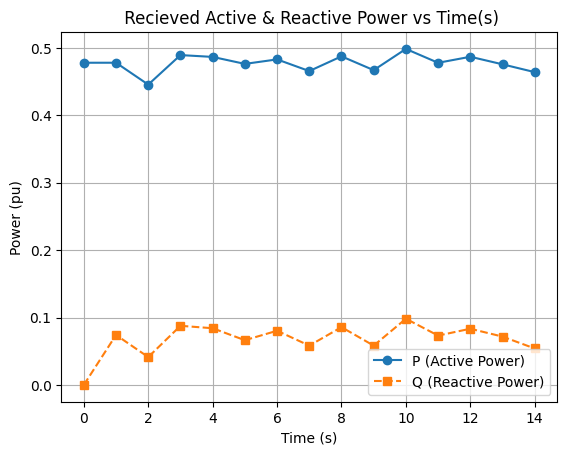

In [11]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.figure(figsize=(6.4, 4.8))
plt.plot(time_list, P_active, label="P (Active Power)", marker='o', linestyle='-')
plt.plot(time_list, Q_reactive, label="Q (Reactive Power)", marker='s', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Power (pu)")
plt.title(" Recieved Active & Reactive Power vs Time(s)")
plt.legend()
plt.grid(True)
plt.show()


Here, we plot frequency at bus 4 (load bus) of transmission system.

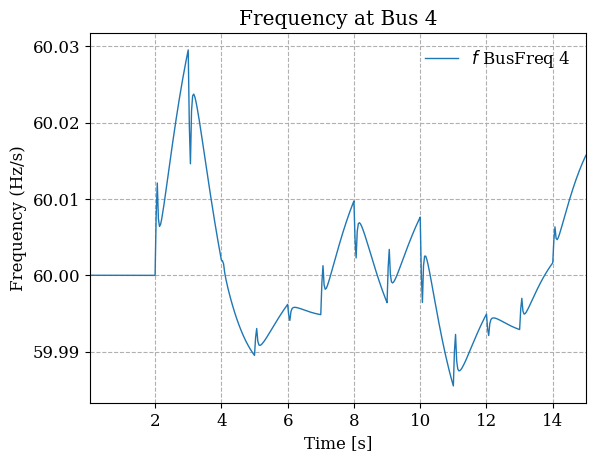

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Frequency at Bus 4'}, xlabel='Time [s]', ylabel='Frequency (Hz/s)'>)

In [12]:
ss.TDS.load_plotter()
ss.TDS.plt.plot(ss.BusFreq.f,ylabel='Frequency (Hz/s)',a=(3,),ytimes=60,title='Frequency at Bus 4',grid=True)

# Result Analysis
At every 1 second, the transmission federate receives P and Q values for the load at bus 4 from the distribution federate. Since there is load variation in the distribution feeder at each second, it can be observed in the P & Q values received by the transmission federate. After receiving the values of P & Q, the transmission federate runs the simulation for the next time steps and sends the voltage magnitude and angle to the distribution federate through publication.

# References

1. T. D. Hardy, B. Palmintier, P. L. Top, D. Krishnamurthy, and J. C. Fuller, "Helics: A co-simulation framework for scalable multi-domain modeling and analysis," IEEE Access, vol. 12, pp.24 325–24 347, 2024.
2. W. Wang, X. Fang, H. Cui, F. Li, Y. Liu, and T. J. Overbye, "Transmission-and-distribution dynamic co-simulation framework for distributed energy resource frequency response," IEEE Transactions on Smart Grid, vol. 13, no. 1, pp. 482–495, 2021.
3. H. Cui, F. Li, and K. Tomsovic, "Hybrid symbolic-numeric framework for power system modeling and analysis," IEEE Trans. Power Syst., vol. 36, no. 2, pp. 1373–1384, 2021.
4. ANDES Documentation: https://docs.andes.app/
